Load moduels

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as sc
from sklearn.metrics import accuracy_score as ac
from imblearn.over_sampling import BorderlineSMOTE
import time

In [2]:
train_csv = pd.read_csv('train.csv')
test_csv = pd.read_csv('test.csv')
train_csv.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Preprocessing

In [3]:
def preprocess(df, train = True):
    # Drop columns
    df = df.drop('id', axis = 1)
    
    # Label Encoding
    df = df.replace(to_replace='Male', value=1).replace(to_replace='Female', value=0)
    df = df.replace(to_replace='> 2 Years', value=0).replace(to_replace='1-2 Year', value=1).replace(to_replace='< 1 Year', value=1)
    df = df.replace(to_replace='Yes', value=1).replace(to_replace='No', value=0)
    
    # Slicing
    if train:
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
    else:
        X = df.values

    # Scaling
    scaler = sc()
    scaler.fit(X)
    X = scaler.transform(X) 

    if train:
        return X, y
    else:
        return X

In [4]:
train_x, train_y = preprocess(train_csv)
test_x = preprocess(test_csv, train = False)

Validation dataset

In [5]:
train_x, valid_x, train_y, valid_y = train_test_split(train_x,
                                                    train_y,
                                                    test_size = 0.2,
                                                    random_state = 1221)   # my B-day

In [6]:
print(f'The number of train set is {len(train_x)}')
print(f'The number of valid set is {len(valid_x)}')
print(f'The number of test set is {len(test_x)}')

The number of train set is 304887
The number of valid set is 76222
The number of test set is 127037


Up sampling

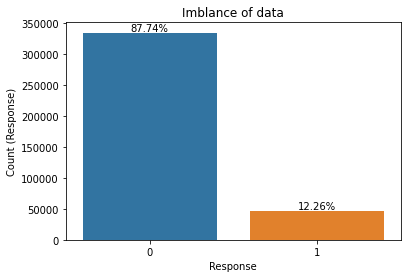

In [7]:
sns.countplot(data = train_csv, x = 'Response')

# Text
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,   
            height + 2,  
            '{:.2f}%'.format(100*(height/len(train_csv['Response']))), 
            fontsize=10,    
            ha='center', va='bottom')

# Title, Label
plt.title('Imblance of data')
plt.ylabel('Count (Response)')
plt.show()

In [17]:
# Smote Algorithm
smote = BorderlineSMOTE()
train_x, train_y = smote.fit_resample(train_x,train_y)

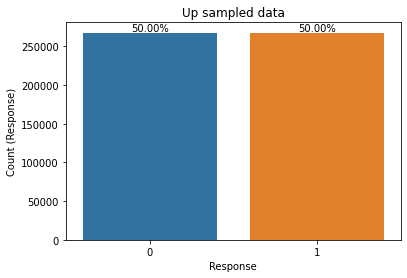

In [19]:
sns.countplot(data = pd.DataFrame({'Response' : train_y}), x = 'Response')

# Text
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,   
            height + 2,  
            '{:.2f}%'.format(100*(height/len(train_y))), 
            fontsize=10,    
            ha='center', va='bottom')

# Title & Label
plt.title('Up sampled data')
plt.ylabel('Count (Response)')
plt.show()

modeling

    Gradient Boosting Regressor

In [27]:
class GBregressor:
    def __init__(self):
        self.model = GradientBoostingRegressor()

    def train(self, x, y):
        start_time = time.time()
        self.model.fit(x, y)
        end_time = time.time()
        print(f'Time for training : {int(end_time - start_time)}')

    def predict(self, x, criterion = None):
        prediction = self.model.predict(x)
        if criterion is None:
            return prediction
        else:
            result = []
            for pred in prediction:
                if pred>criterion:
                    result.append(1)
                else:
                    result.append(0)        
            return result

In [28]:
model = GBregressor()
model.train(train_x, train_y)

Time for training : 102


Visualize

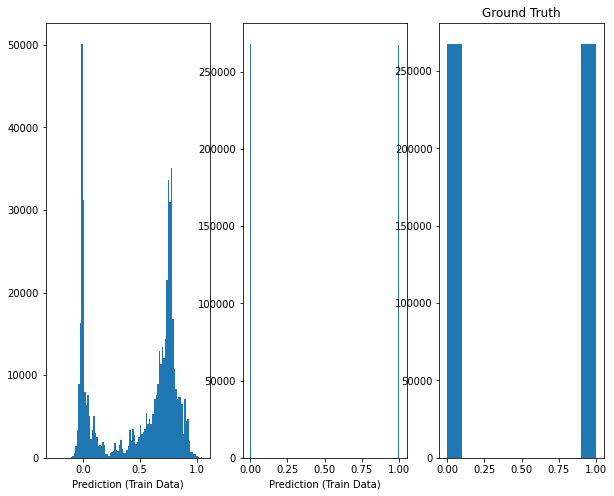

In [30]:
fig, ax = plt.subplots(1, 3, figsize = (10, 8))
ax[0].hist(model.predict(train_x), bins = 100)
ax[0].set_xlabel('Prediction (Train Data)')
ax[1].hist(model.predict(train_x, criterion = np.median(model.predict(train_x))), bins = 100)
ax[1].set_xlabel('Prediction (Train Data)')
ax[2].hist(train_y)
ax[2].set_title('Ground Truth')
plt.show()

In [31]:
median = np.median(model.predict(train_x))
print(f'median of prediction of train x : {median}')

median of prediction of train x : 0.6755087380105894


Evaluate

In [32]:
prediction = model.predict(valid_x, criterion = median)
print(f'Accuracy of validation set is {ac(prediction, valid_y)}')

Accuracy of validation set is 0.7987195297945475


Submission

In [47]:
test_df = preprocess(test_csv, train = False)
prediction = model.predict(test_df, criterion = median)
submission = pd.DataFrame({'id' : test_csv.id.values, 'Response' : prediction})
submission.to_csv('submission.csv', header = None, index = False)
submission.head()

<AxesSubplot:xlabel='Response', ylabel='count'>

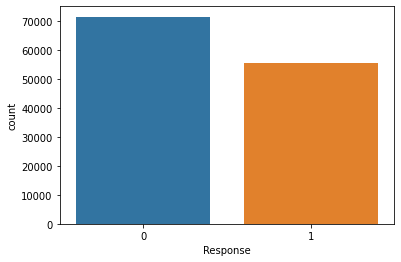

In [50]:
plt.title('Submission Countplot')
sns.countplot(data = submission, x = 'Response')
plt.show()